#Brain Tumor Detection
This notebook train a model with brain images with synthetic tumor using MONAI and PyTorch.

In [1]:
# Clone the repo for using the dataset
!git clone https://github.com/MoriahDavid/Synthetic-3D-Tumors.git

Cloning into 'Synthetic-3D-Tumors'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 21 (delta 4), reused 14 (delta 1), pack-reused 3 (from 1)
Receiving objects: 100% (21/21), 42.09 MiB | 19.35 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
!unzip -qo /content/Synthetic-3D-Tumors/dataset.zip -d /content/dataset

In [3]:
import os

def print_file_counts(folder_path):
    for root, _, files in os.walk(folder_path):
      if len(files) > 0: print(f"{root}: {len(files)} files")

print_file_counts('/content/dataset1')

In [ ]:
# Comment out this block for traning the model without the sythetic tumor data
!cp /content/dataset/generated_data/no/* /content/dataset/Train/no
!cp /content/dataset/generated_data/yes/* /content/dataset/Train/yes

Install MONAI

In [5]:
!pip install -q "monai[gdown, nibabel, tqdm, itk]==0.8.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.8/709.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 41.9 MB/s eta 0:00:00


In [6]:
import os
import shutil
import tempfile
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism


## Read image filenames from the dataset folders

In [7]:
class_names=['no', 'yes']

In [8]:
def load_data(data_dir):
  image_files = [[os.path.join(data_dir, class_name, x)
                for x in os.listdir(os.path.join(data_dir, class_name))]
               for class_name in class_names]

  image_file_list = []
  image_label_list = []
  for i, class_name in enumerate(class_names):
      image_file_list.extend(image_files[i])
      image_label_list.extend([i] * len(image_files[i]))
  num_total = len(image_label_list)
  print(image_file_list[0:10])
  print(image_label_list[0:10])
  return image_file_list, image_label_list

In [9]:
trainX, trainY = load_data('/content/dataset/Train')
valX, valY = load_data('/content/dataset/Validation')
testX, testY = load_data('/content/dataset/Test')


print(len(trainX),len(valX),len(testX))

['/content/dataset/Train/no/no 96.jpg', '/content/dataset/Train/no/image(197).jpg', '/content/dataset/Train/no/image(104).jpg', '/content/dataset/Train/no/image(71).jpg', '/content/dataset/Train/no/image(262).jpg', '/content/dataset/Train/no/image(83).jpg', '/content/dataset/Train/no/image(301).jpg', '/content/dataset/Train/no/image (43).jpg', '/content/dataset/Train/no/image(88).jpg', '/content/dataset/Train/no/image (14).jpg']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['/content/dataset/Validation/no/42 no.jpg', '/content/dataset/Validation/no/49 no.jpg', '/content/dataset/Validation/no/43 no.jpg', '/content/dataset/Validation/no/17 no.jpg', '/content/dataset/Validation/no/no 4.jpg', '/content/dataset/Validation/no/image(107).jpg', '/content/dataset/Validation/no/6.jpg', '/content/dataset/Validation/no/No13.jpg', '/content/dataset/Validation/no/image(100).jpg', '/content/dataset/Validation/no/7 no.jpg']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['/content/dataset/Test/no/v_7 no.jpg', '/content/dataset/Tes

## Visualise some examples

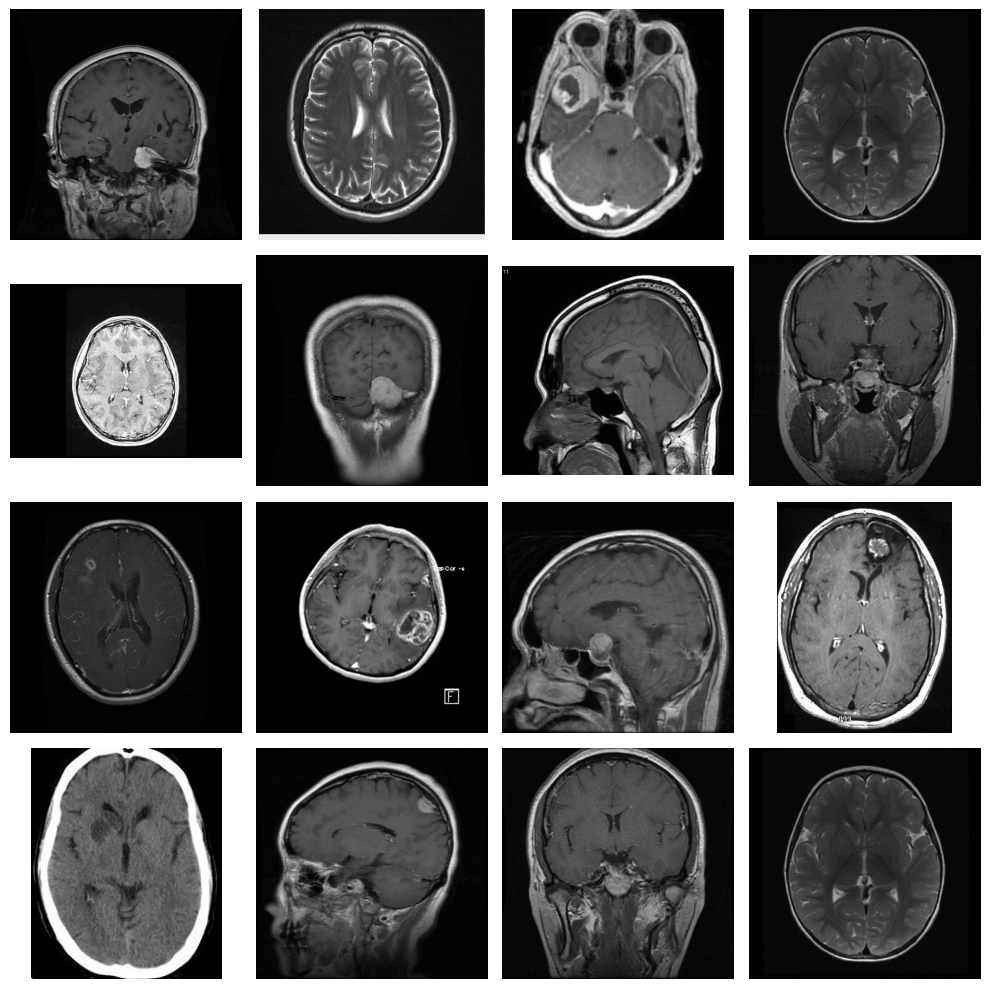

In [30]:
plt.subplots(4,4, figsize=(10,10))
for i,k in enumerate(np.random.randint(len(testX), size=16)):
    im = Image.open(testX[k])
    arr = np.array(im)
    plt.subplot(4,4, i + 1)
    plt.xlabel(class_names[testY[k]])
    plt.axis('off')
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [9]:
class MyResize(Transform):
    def __init__(self, size=(160,160)):
        self.size = size
    def __call__(self, inputs):
        image2=cv2.resize(inputs,dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        return image2

In [60]:
train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(),
    AddChannel(),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(),
    AddChannel(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=2)#num_class)

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.


In [43]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [61]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=2)

In [45]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=2 # number of classes
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 40
val_interval = 1

## Model training


In [46]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)

            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')

            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/40
1/28, train_loss: 0.6470
2/28, train_loss: 0.6673
3/28, train_loss: 0.6721
4/28, train_loss: 0.6645
5/28, train_loss: 0.6604
6/28, train_loss: 0.6531
7/28, train_loss: 0.6361
8/28, train_loss: 0.6951
9/28, train_loss: 0.5908
10/28, train_loss: 0.5989
11/28, train_loss: 0.6071
12/28, train_loss: 0.6226
13/28, train_loss: 0.6196
14/28, train_loss: 0.6988
15/28, train_loss: 0.5992
16/28, train_loss: 0.6473
17/28, train_loss: 0.6007
18/28, train_loss: 0.6809
19/28, train_loss: 0.7000
20/28, train_loss: 0.5913
21/28, train_loss: 0.5990
22/28, train_loss: 0.7261
23/28, train_loss: 0.5839
24/28, train_loss: 0.4681
25/28, train_loss: 0.6187
26/28, train_loss: 0.6185
27/28, train_loss: 0.7002
28/28, train_loss: 0.6321
epoch 1 average loss: 0.6357
saved new best metric model
current epoch: 1 current AUC: 0.7180 current accuracy: 0.5900 best AUC: 0.5900 at epoch: 1
----------
epoch 2/40
1/28, train_loss: 0.6192
2/28, train_loss: 0.5839
3/28, train_loss: 0.5755
4/28, train_lo

## Plot the loss and metric

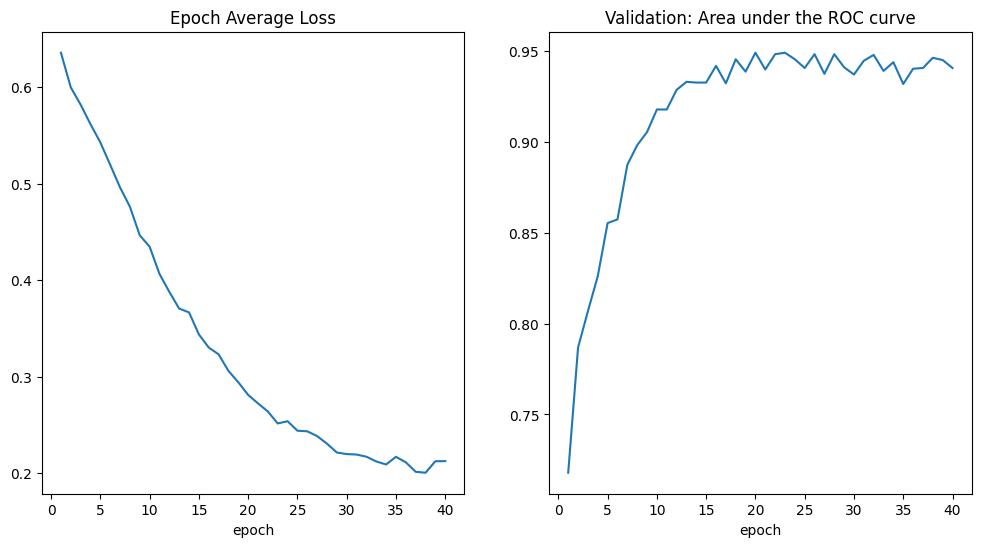

In [47]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset
- After training and verification, we have already obtained the best model in the verification test.
- You should evaluate your model in a test dataset to see if it is robust and overfitting.

In [67]:
model.load_state_dict(torch.load('/content/best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [69]:
torch.cuda.empty_cache()

In [68]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

          no     0.8696    0.9524    0.9091       147
         yes     0.9474    0.8571    0.9000       147

    accuracy                         0.9048       294
   macro avg     0.9085    0.9048    0.9045       294
weighted avg     0.9085    0.9048    0.9045       294



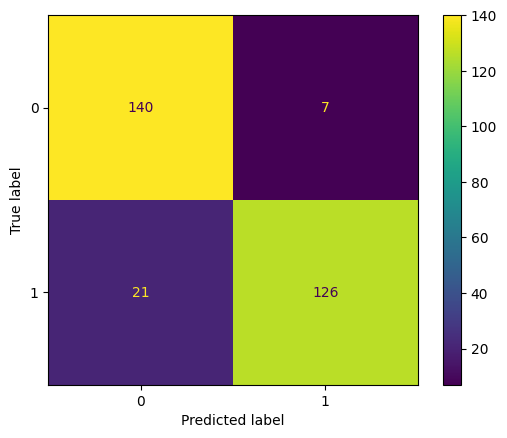

In [70]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()